In [1]:
# Cell 0: Env & reproducibility (CPU-only)
import os, random, numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU

import torch
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.set_num_threads(4)
DEVICE = torch.device("cpu")
DEVICE


device(type='cpu')

In [ ]:
# Cell 1: Load ETH + split
import pandas as pd

PATH = "/Users/dophi/Desktop/btl_doan2/crypto-prediction/data/processed/ETHUSDT_1d_features.csv"  # ETH file
df = pd.read_csv(PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

In [3]:
n = len(df)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
n_test  = n - n_train - n_val

train_df = df.iloc[:n_train].copy()
val_df   = df.iloc[n_train:n_train+n_val].copy()
test_df  = df.iloc[n_train+n_val:].copy()

(len(train_df), len(val_df), len(test_df), df["datetime"].min(), df["datetime"].max())

(749,
 160,
 162,
 Timestamp('2022-12-04 07:00:00'),
 Timestamp('2025-11-08 07:00:00'))

In [4]:
from sklearn.preprocessing import MinMaxScaler

FEATURE_COLS = [
    "close","high","low","volume","MA_7","MA_25","RSI_14",
    "price_change_pct","volume_change_pct","hl_range_pct"
]
TARGET_COL = "close"
assert all(c in df.columns for c in FEATURE_COLS+[TARGET_COL])

In [5]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[FEATURE_COLS].values)
y_train = scaler_y.fit_transform(train_df[[TARGET_COL]].values)

X_val   = scaler_X.transform(val_df[FEATURE_COLS].values)
y_val   = scaler_y.transform(val_df[[TARGET_COL]].values)

X_test  = scaler_X.transform(test_df[FEATURE_COLS].values)
y_test  = scaler_y.transform(test_df[[TARGET_COL]].values)

In [6]:
# Cell 3: Sequence builder
import numpy as np

def make_sequences(X, y, seq_len: int):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])   # (seq_len, n_features)
        ys.append(y[i])             # (1,)
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)


In [7]:
# Cell 4: Model & evaluation
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import math

class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

In [8]:
def rmse_percent(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mean_true = np.mean(y_true)
    return 100.0 * rmse / (mean_true + 1e-8)

@torch.no_grad()
def evaluate(model, loader, scaler_y):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        out = model(xb.to(DEVICE))
        y_pred = scaler_y.inverse_transform(out.cpu().numpy())
        y_true = scaler_y.inverse_transform(yb.cpu().numpy())
        preds.append(y_pred); trues.append(y_true)
    y_pred = np.vstack(preds); y_true = np.vstack(trues)
    rmse  = math.sqrt(mean_squared_error(y_true, y_pred))
    rmse_pct = rmse_percent(y_true, y_pred)
    return rmse, rmse_pct, y_true.squeeze(), y_pred.squeeze()


In [9]:
# Cell 5: DataLoaders + train loop + early stopping (return best_epoch)
from torch.utils.data import TensorDataset, DataLoader

def build_loaders(seq_len, batch_size):
    Xtr, ytr = make_sequences(X_train, y_train, seq_len)
    Xv,  yv  = make_sequences(X_val,   y_val,   seq_len)
    Xt,  yt  = make_sequences(X_test,  y_test,  seq_len)

    train_loader = DataLoader(
        TensorDataset(torch.tensor(Xtr), torch.tensor(ytr)),
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.tensor(Xv), torch.tensor(yv)),
        batch_size=batch_size, shuffle=False
    )
    test_loader = DataLoader(
        TensorDataset(torch.tensor(Xt), torch.tensor(yt)),
        batch_size=batch_size, shuffle=False
    )
    return train_loader, val_loader, test_loader

def train_model(cfg):
    seq_len      = cfg["seq_len"]
    hidden_size  = cfg["hidden_size"]
    num_layers   = cfg["num_layers"]
    dropout      = cfg["dropout"]
    lr           = cfg["lr"]
    batch_size   = cfg["batch_size"]
    max_epochs   = cfg.get("max_epochs", 250)
    patience     = cfg.get("patience", 25)

    train_loader, val_loader, test_loader = build_loaders(seq_len, batch_size)

    model = LSTMRegressor(
        n_features=len(FEATURE_COLS),
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    best_epoch = 0
    wait = 0

    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        val_rmse, val_rmse_pct, _, _ = evaluate(model, val_loader, scaler_y)
        if val_rmse_pct < best_val:
            best_val = val_rmse_pct
            best_state = model.state_dict()
            best_epoch = epoch
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    model.load_state_dict(best_state)
    tr_rmse, tr_rmse_pct, _, _ = evaluate(model, train_loader, scaler_y)
    v_rmse,  v_rmse_pct,  _, _ = evaluate(model, val_loader, scaler_y)
    t_rmse,  t_rmse_pct,  y_true, y_pred = evaluate(model, test_loader, scaler_y)

    return {
        "cfg": cfg,
        "model": model,
        "loaders": (train_loader, val_loader, test_loader),
        "metrics": {
            "train": (tr_rmse, tr_rmse_pct),
            "val":   (v_rmse,  v_rmse_pct),
            "test":  (t_rmse,  t_rmse_pct),
        },
        "y_true_test": y_true,
        "y_pred_test": y_pred,
        "best_epoch": best_epoch
    }


In [10]:
# Cell 6: Small grid search (ETH)
grid = []
for seq_len in [30, 60, 90]:
    for hidden_size in [64, 128]:
        for num_layers in [1, 2]:
            for dropout in [0.1, 0.3]:
                for lr in [1e-3, 5e-4]:
                    for batch_size in [32, 64]:
                        grid.append({
                            "seq_len": seq_len,
                            "hidden_size": hidden_size,
                            "num_layers": num_layers,
                            "dropout": dropout,
                            "lr": lr,
                            "batch_size": batch_size,
                            "max_epochs": 250,
                            "patience": 25
                        })
len(grid)


96

In [11]:
# Cell 6b: Run grid & pick best
best = None
for i, cfg in enumerate(grid, 1):
    result = train_model(cfg)
    val_rmse_pct = result["metrics"]["val"][1]
    if (best is None) or (val_rmse_pct < best["metrics"]["val"][1]):
        best = result
    if i % 5 == 0:
        print(f"Checked {i}/{len(grid)}; current best Val RMSE% = {best['metrics']['val'][1]:.3f} with cfg={best['cfg']}")
best["cfg"], best["metrics"], best["best_epoch"]


Checked 5/96; current best Val RMSE% = 4.765 with cfg={'seq_len': 30, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32, 'max_epochs': 250, 'patience': 25}
Checked 10/96; current best Val RMSE% = 4.637 with cfg={'seq_len': 30, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32, 'max_epochs': 250, 'patience': 25}
Checked 15/96; current best Val RMSE% = 4.637 with cfg={'seq_len': 30, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32, 'max_epochs': 250, 'patience': 25}
Checked 20/96; current best Val RMSE% = 4.626 with cfg={'seq_len': 30, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32, 'max_epochs': 250, 'patience': 25}
Checked 25/96; current best Val RMSE% = 4.600 with cfg={'seq_len': 30, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32, 'max_epochs': 250, 'patience': 25}
Checked 30/96; current best Val RMSE% = 4.446 with cfg

({'seq_len': 30,
  'hidden_size': 128,
  'num_layers': 2,
  'dropout': 0.3,
  'lr': 0.001,
  'batch_size': 64,
  'max_epochs': 250,
  'patience': 25},
 {'train': (80.00897166490142, 3.3208623904556585),
  'val': (100.80671674360295, 4.446106534663619),
  'test': (259.5035223749381, 6.586887886847952)},
 134)

In [ ]:
# Cell 7: Train+Val fine-tune (no leakage; keep scalers from train)
from torch.utils.data import TensorDataset, DataLoader

#def build_loader_trainval(seq_len, batch_size):
    X_trv = np.vstack([X_train, X_val])
    y_trv = np.vstack([y_train, y_val])
    Xs, ys = make_sequences(X_trv, y_trv, seq_len)
    return DataLoader(TensorDataset(torch.tensor(Xs), torch.tensor(ys)),
                      batch_size=batch_size, shuffle=True, drop_last=True)

cfg = best["cfg"].copy()
seq_len = cfg["seq_len"]
batch_size = cfg["batch_size"]
best_epoch = best.get("best_epoch", 50)

trainval_loader = build_loader_trainval(seq_len, batch_size)

model = LSTMRegressor(
    n_features=len(FEATURE_COLS),
    hidden_size=cfg["hidden_size"],
    num_layers=cfg["num_layers"],
    dropout=cfg["dropout"]
).to(DEVICE)

fine_tune_lr = cfg["lr"] * 0.2
opt = torch.optim.Adam(model.parameters(), lr=fine_tune_lr)
loss_fn = nn.MSELoss()

EPOCHS = max(20, best_epoch)
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in trainval_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

# evaluate test
_, _, test_loader = best["loaders"]
eth_test_rmse, eth_test_rmse_pct, eth_true_test, eth_pred_test = evaluate(model, test_loader, scaler_y)
eth_test_rmse, eth_test_rmse_pct


(206.49020103869336, 5.241269141655104)

In [ ]:
# Cell 8: Save/Load helpers (ETH/BTC dùng chung)
import os, json, time, torch

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def save_checkpoint(symbol, model, cfg, scaler_X, scaler_y, timeframe="1d", extra_info=None, base_dir="/Users/dophi/Desktop/btl_doan2/crypto-prediction/models"):
    ensure_dir(base_dir)
    ts = time.strftime("%Y%m%d_%H%M%S")
    fname = f"{symbol}_{timeframe}_lstm_seq{cfg['seq_len']}_h{cfg['hidden_size']}_L{cfg['num_layers']}_do{cfg['dropout']}_bs{cfg['batch_size']}_{ts}.pt"
    path = os.path.join(base_dir, fname)
    payload = {
        "model_state_dict": model.state_dict(),
        "config": cfg,
        "symbol": symbol,
        "feature_cols": FEATURE_COLS,
        "target_col": TARGET_COL,
        "extra": extra_info or {},
        "timestamp": ts,
        "scaler_X": scaler_X,
        "scaler_y": scaler_y,
    }
    torch.save(payload, path)
    print(f"✅ Saved {symbol} checkpoint to: {path}")
    return path

def load_checkpoint(path, device=DEVICE):
    ckpt = torch.load(path, map_location=device)
    model = LSTMRegressor(
        n_features=len(ckpt["feature_cols"]),
        hidden_size=ckpt["config"]["hidden_size"],
        num_layers=ckpt["config"]["num_layers"],
        dropout=ckpt["config"]["dropout"]
    ).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    return model, ckpt["config"], ckpt["feature_cols"], ckpt["target_col"], ckpt["scaler_X"], ckpt["scaler_y"], ckpt.get("symbol", "UNKNOWN")


In [15]:
# Cell 9: Save ETH checkpoint
eth_path = save_checkpoint(
    symbol="ETHUSDT",
    model=model,
    cfg=cfg,
    scaler_X=scaler_X,   # ETH scalers!
    scaler_y=scaler_y,
    timeframe="1d",
    extra_info={
        "best_epoch": best.get("best_epoch", None),
        "metrics": {"test_rmse": float(eth_test_rmse), "test_rmse_pct": float(eth_test_rmse_pct)}
    }
)
eth_path


✅ Saved ETHUSDT checkpoint to: models/crypto_lstm/ETHUSDT_1d_lstm_seq30_h128_L2_do0.3_bs64_20251110_131416.pt


'models/crypto_lstm/ETHUSDT_1d_lstm_seq30_h128_L2_do0.3_bs64_20251110_131416.pt'

ETH Test MAE   = 162.4246
ETH Test RMSE  = 206.4902  (5.24%)
ETH Test MAPE  = 3.96%
ETH Test sMAPE = 4.05%
R² Score = 0.8738


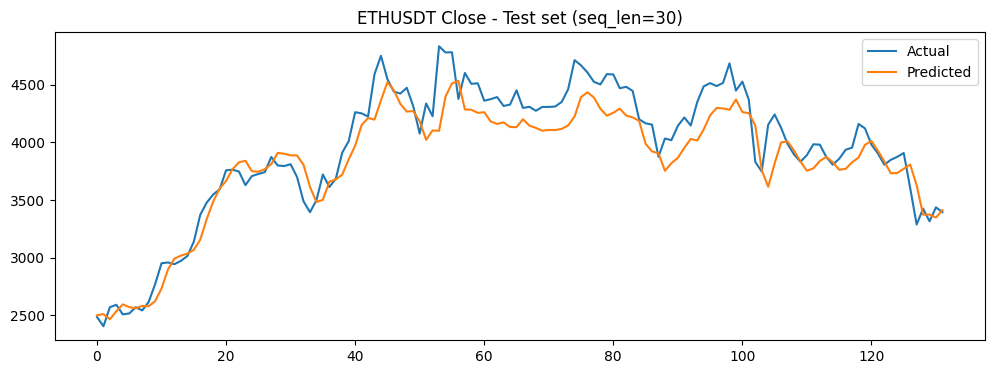

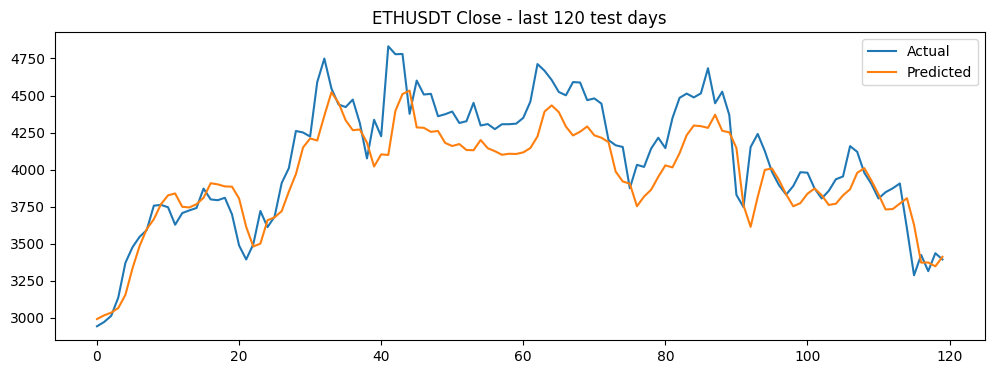

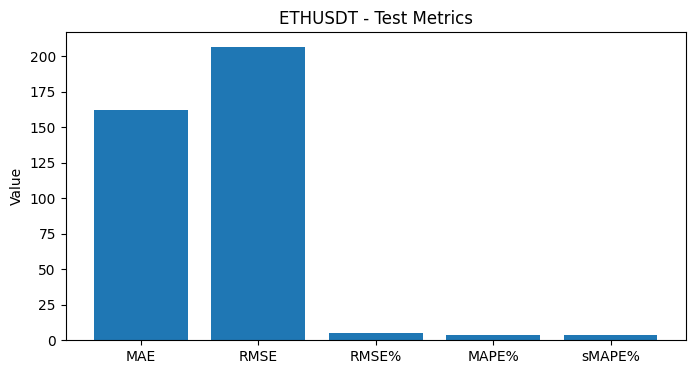

In [ ]:
# Cell 10: Metrics + plots (Actual vs Predicted)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import math

# Rebuild test sequences with saved scalers to be explicit
X_test_eth = scaler_X.transform(test_df[FEATURE_COLS].values)
y_test_eth = scaler_y.transform(test_df[[TARGET_COL]].values)
Xte_seq, yte_seq = make_sequences(X_test_eth, y_test_eth, seq_len)

test_loader_eth = DataLoader(TensorDataset(torch.tensor(Xte_seq), torch.tensor(yte_seq)),
                             batch_size=64, shuffle=False)

model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader_eth:
        out = model(xb.to(DEVICE))
        y_pred = scaler_y.inverse_transform(out.cpu().numpy()); preds.append(y_pred)
        y_true = scaler_y.inverse_transform(yb.cpu().numpy()); trues.append(y_true)

y_pred = np.vstack(preds).squeeze()
y_true = np.vstack(trues).squeeze()

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100.0

def smape(y_true, y_pred):
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse_pct = 100.0 * rmse / (np.mean(y_true) + 1e-8)
r2 = r2_score(y_true, y_pred)

print(f"ETH Test MAE   = {mae:.4f}")
print(f"ETH Test RMSE  = {rmse:.4f}  ({rmse_pct:.2f}%)")
print(f"R² Score = {r2:.4f}")

# Plot 1: full test
plt.figure(figsize=(12,4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title(f"ETHUSDT Close - Test set (seq_len={seq_len})")
plt.legend()
plt.show()

# Plot 2: last 120 days
last_n = 120 if len(y_true) >= 120 else len(y_true)
plt.figure(figsize=(12,4))
plt.plot(y_true[-last_n:], label="Actual")
plt.plot(y_pred[-last_n:], label="Predicted")
plt.title(f"ETHUSDT Close - last {last_n} test days")
plt.legend()
plt.show()

# Plot 3: Metrics bar
metrics = {"MAE": mae, "RMSE": rmse, "RMSE%": rmse_pct, "MAPE%": mape_v, "sMAPE%": smape_v}
plt.figure(figsize=(8,4))
plt.bar(list(metrics.keys()), list(metrics.values()))
plt.title("ETHUSDT - Test Metrics")
plt.ylabel("Value")
plt.show()
